In [1]:
datasetName = 'brain_FetalBrain5_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_FetalBrain5_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalBrain_5.ACGTTGATACAGTAGTCG,FetalBrain_5.ACGTTGCACAAGGCTGTG,FetalBrain_5.AACCTATTGGACAGGGTC,FetalBrain_5.ACGTTGCTTCTGCTTCTG,FetalBrain_5.ACGTTGCTCGCAAGTCGT
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A1CF,0,0,0,0,0
A2M,0,0,0,0,0
A2ML1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalBrain_5.ACGTTGATACAGTAGTCG,brain,FetalBrain,FetalBrain,normal,Donor10,female,12 weeks old
FetalBrain_5.ACGTTGCACAAGGCTGTG,brain,FetalBrain,FetalBrain,normal,Donor10,female,12 weeks old
FetalBrain_5.AACCTATTGGACAGGGTC,brain,FetalBrain,FetalBrain,normal,Donor10,female,12 weeks old
FetalBrain_5.ACGTTGCTTCTGCTTCTG,brain,FetalBrain,FetalBrain,normal,Donor10,female,12 weeks old
FetalBrain_5.ACGTTGCTCGCAAGTCGT,brain,FetalBrain,FetalBrain,normal,Donor10,female,12 weeks old


[1] Fetal neuron   Fetal neuron   Fetal neuron   Fetal neuron   Erythroid cell
17 Levels: Antigen presenting cell (RPS high) CB CD34+ ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


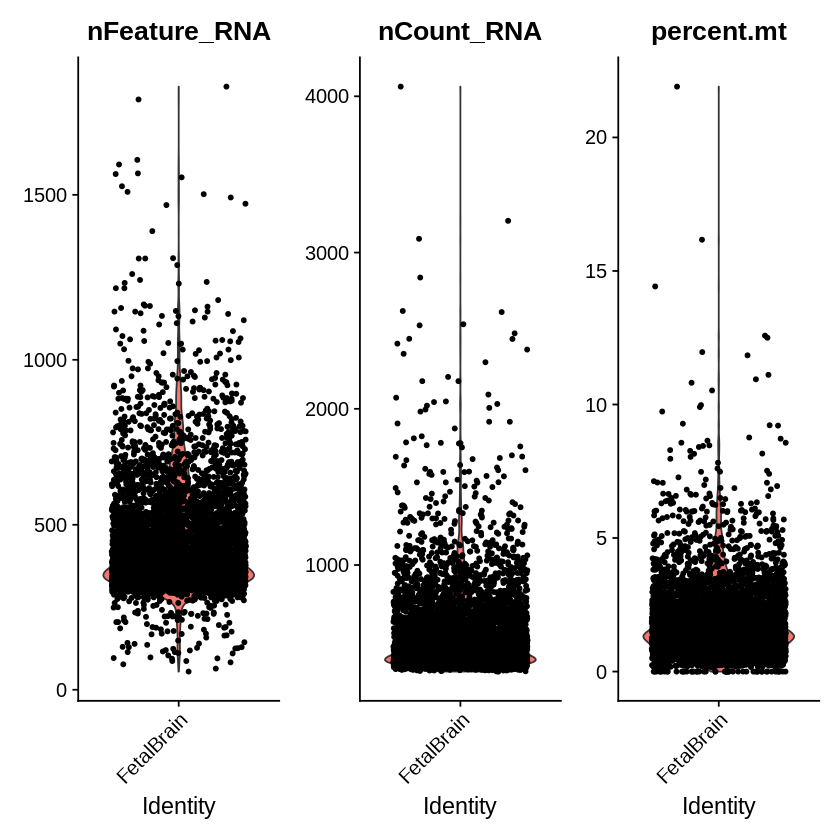

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  SPARC, NID2, OGN, COL1A2, DCN, GJA1, COL3A1, IFITM3, ANXA2, S100A11 
	   COL1A1, ISLR, LGALS1, FN1, IGFBP7, LAMB1, FOLR1, PLTP, LUM, SERPINF1 
	   FSTL1, S100A10, APOD, CA2, TTR, SULT1E1, CFAP126, PIFO, COL5A2, FBLN1 
Negative:  TUBA1A, TMSB15A, PTMA, STMN2, C1orf61, SOX4, GPM6A, PPP1R17, STMN1, CKS2 
	   FABP7, CALM2, PTTG1, HMGB2, UBE2T, H2AFZ, HSP90AA1, LINC01158, UBE2C, TMSB10 
	   KPNA2, NUF2, NUSAP1, MAD2L1, SMC4, DNAJB1, AURKB, CCNB2, CALB2, CDK1 
PC_ 2 
Positive:  DCN, COL3A1, OGN, COL1A2, LGALS1, COL1A1, ISLR, FN1, LUM, S100A11 
	   GJA1, NID1, APOD, PTN, SULT1E1, COL6A3, OLFML3, CXCL12, CFH, COL4A1 
	   FRZB, COL5A1, CDH11, ASPN, AKAP12, CTSC, LAMA4, CYP1B1, PCOLCE, COL5A2 
Negative:  FOLR1, CFAP126, C1orf194, TTR, PIFO, C11orf88, FAM183A, IGFBP7, C9orf24, TRPM3 
	   KCNJ13, CAPSL, C20orf85, CA2, DYNLRB2, SLC13A4, VAT1L, FAM81B, TPPP3, MORN5 
	   KIF9, C9orf135, RSPH1, C9orf116, GRAMD3, TCTEX1D1, SLC39A12, CLIC6, C5orf49, PRNP 
PC_ 3 
Positive:  A2M, C1QB, C

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


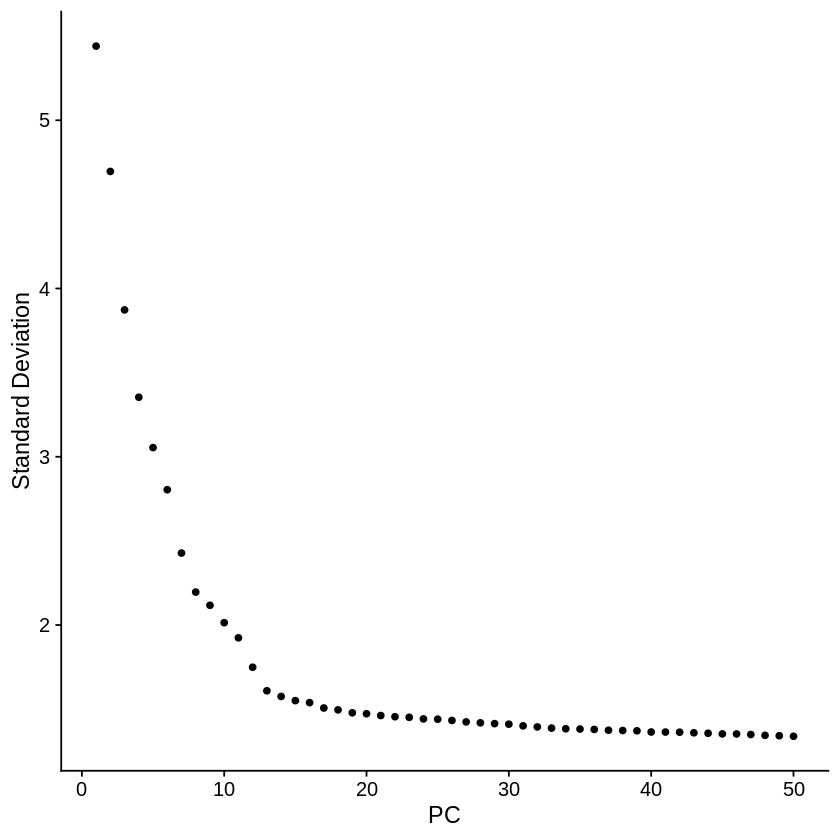

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [25]:
dev.off()
pcDim = 15 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

05:36:56 UMAP embedding parameters a = 0.9922 b = 1.112

05:36:56 Read 5112 rows and found 15 numeric columns

05:36:56 Using Annoy for neighbor search, n_neighbors = 30

05:36:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

05:36:57 Writing NN index file to temp file /tmp/Rtmpb3gfQG/file6c3464ea6939

05:36:57 Searching Annoy index using 1 thread, search_k = 3000

05:36:59 Annoy recall = 100%

05:36:59 Commencing smooth kNN distance calibration using 1 thread

05:37:00 Initializing from normalized Laplacian + noise

05:37:00 Commencing optimization for 500 epochs, with 226416 positive edges

05:37:12 Optimization finished



In [26]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5112
Number of edges: 181388

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8400
Number of communities: 9
Elapsed time: 0 seconds


05:37:14 UMAP embedding parameters a = 0.9922 b = 1.112

05:37:14 Read 5112 rows and found 15 numeric columns

05:37:14 Using Annoy for neighbor search, n_neighbors = 30

05:37:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

05:37:14 Writing NN index file to temp file /tmp/Rtmpb3gfQG/file6c344e1c602a

05:37:14 Searching Annoy index using 1 thread, search_k = 3000

05:37:16 Annoy recall = 100%

05:37:16 Commencing smooth kNN distance calibration using 1 thread

05:37:17 Initializing from normalized Laplacian + noise

05:37:17 Commencing optimization for 500 epochs, with 226416 positive edges

05:37:30 Optimization finished



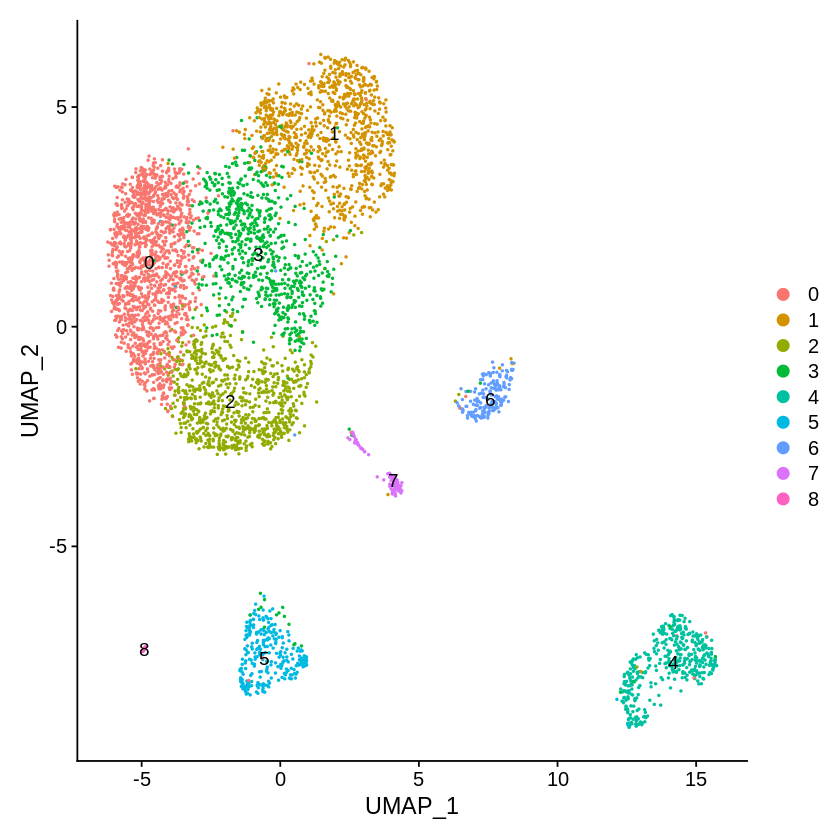

In [27]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [17]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

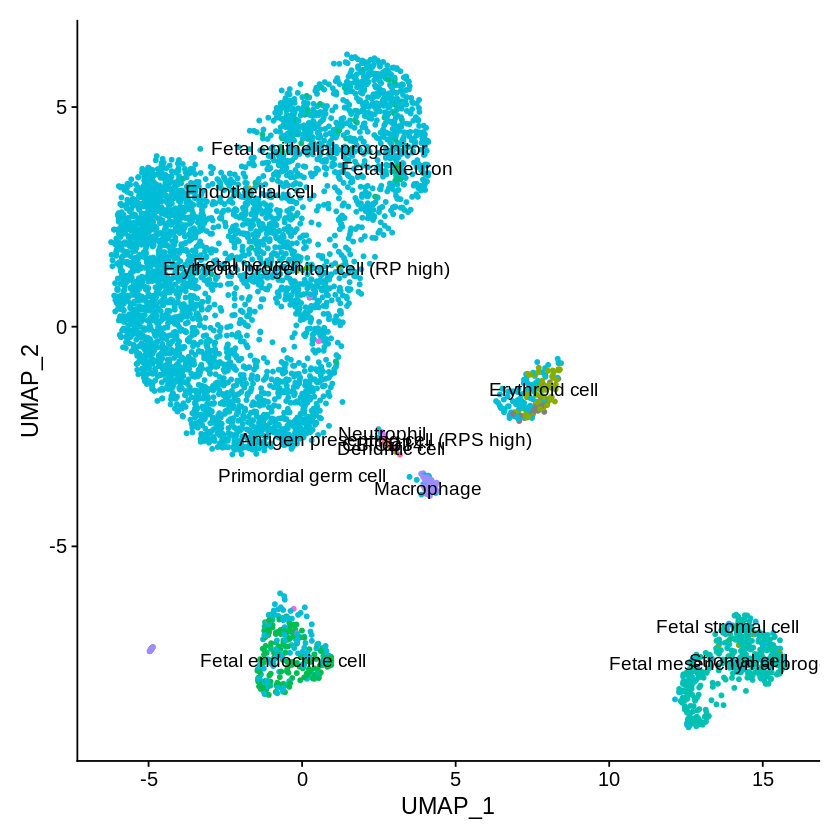

In [28]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [19]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [20]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [29]:
# proliferating radial glia? proliferating cell? erythroid cell?
new.cluster.ids <- c('Brain-Nerve tissue-Neuron-NEUROD6', 'Brain-Nerve tissue-Proliferating cell-KIAA0101', 'Brain-Nerve tissue-Neuron-NEUROD6', 
                    'Brain-Nerve tissue-Proliferating cell-KIAA0101', 'Brain-Nerve tissue-Oligodendrocyte-PTN', 'Brain-Nerve tissue-Ependymal cell-TTR',
                    'Brain-Epithelial tissue-Erythroid cell-HBE1', 'Brain-Nerve tissue-Microglia-AIF1', 'Brain-Nerve tissue-Microglia-AIF1')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [12]:
new.cluster.ids <- c()
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

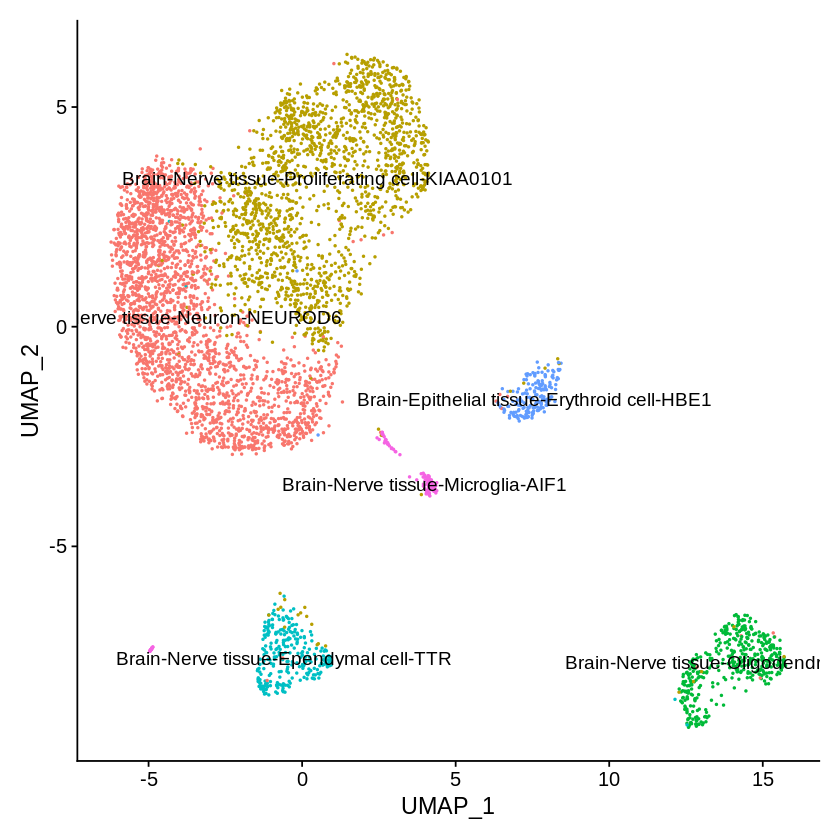

In [30]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [31]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [32]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))